# __AIRFARE PREDICTION__

Airplane is one of the favourite transportation options for some people, whether business purpose or vacation. Buying airplane tickets as preparation when traveling is a common activity to obtain the right airfare. However, the airfare is sometimes difficult to predict. Price with the same date and the same airline can have different price when we book today compared to tomorrow.

As a Data Scientist, We can build a machine learning model as a solution. The model can help to calculate and to predict airfare as accurately as possible. Hopefully, this model can be useful for travelers when planning their budget. In addition, this model also can help airlines to determine new competitive prices.

# 1. Dataset Summary
__Source Dataset__ : [link](https://www.kaggle.com/nikhilmittal/flight-fare-prediction-mh) 

This dataset provides flight tickets from various airlines in India. There are total 10683 rows and 11 features. Information of each feature will be explained below :
- **Airline:** The name of the airline.
- **Date_of_Journey:** The date of the journey
- **Source:** The source from which the service begins.
- **Destination:** The destination where the service ends.
- **Route:** The route taken by the flight to reach the destination.
- **Dep_Time:** The time when the journey starts from the source.
- **Arrival_Time:** Time of arrival at the destination.
- **Duration:** Total duration of the flight.
- **Total_Stops:** Total stops between the source and destination.
- **Additional_Info:** Additional information about the flight
- **Price:** The price of the ticket

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

import category_encoders as ce
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import pickle

In [2]:
pd.set_option('display.max_columns', 25)

In [3]:
train_data = pd.read_excel('Data_Train.xlsx', engine='openpyxl')
train_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [4]:
train_data.shape

(10683, 11)

# 2. Data Pre-Processing and Feature Engineering

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


## A. Handling Missing Value

In [6]:
train_data.isna().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [7]:
train_data.dropna(inplace=True)

In [8]:
train_data.isna().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

There are missing value in `Route` and `Total_Stops` features. However, each feature only has 1 missing value. It can be directly be dropped.

## B. Extract New Features and Data Formatting

### Change Time Data to Datetime Format

`The Date_of_Journey`, `Dep_Time`, `Arrival_Time` features reflect time stamp information. Because the type is object, it should be converted to datetime type. 

In [9]:
train_data.columns

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info', 'Price'],
      dtype='object')

In [10]:
for col in ['Date_of_Journey', 'Dep_Time', 'Arrival_Time'] :
    train_data[col] = pd.to_datetime(train_data[col])

In [11]:
train_data.dtypes

Airline                    object
Date_of_Journey    datetime64[ns]
Source                     object
Destination                object
Route                      object
Dep_Time           datetime64[ns]
Arrival_Time       datetime64[ns]
Duration                   object
Total_Stops                object
Additional_Info            object
Price                       int64
dtype: object

### Extract Features from Date of Journey
Extract day and month from `Date_of_Journey` as new features (`Journey_Day` and `Journey_Month`).

In [12]:
train_data['Journey_Day'] = train_data['Date_of_Journey'].dt.day
train_data['Journey_Month'] = train_data['Date_of_Journey'].dt.month

In [13]:
train_data.drop('Date_of_Journey', axis=1, inplace=True)

### Extract Features from Departure Time
Extract hour and minute from `Dep_Time` as new features (`Dep_Time_Hours` and `Dep_Time_Minutes`).

In [14]:
train_data.head()

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_Day,Journey_Month
0,IndiGo,Banglore,New Delhi,BLR → DEL,2021-06-03 22:20:00,2021-03-22 01:10:00,2h 50m,non-stop,No info,3897,24,3
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2021-06-03 05:50:00,2021-06-03 13:15:00,7h 25m,2 stops,No info,7662,5,1
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2021-06-03 09:25:00,2021-06-10 04:25:00,19h,2 stops,No info,13882,6,9
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,2021-06-03 18:05:00,2021-06-03 23:30:00,5h 25m,1 stop,No info,6218,5,12
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,2021-06-03 16:50:00,2021-06-03 21:35:00,4h 45m,1 stop,No info,13302,3,1


In [15]:
def extract_hour(df, col) :
    df[col+"_Hours"] = df[col].dt.hour
    
def extract_min(df, col) :
    df[col+"_Minutes"] = df[col].dt.minute

In [16]:
extract_hour(train_data, 'Dep_Time')
extract_min(train_data, 'Dep_Time')

### Extract Features from Arrival Time
Extract hour and minute from `Arrival_Time` as new features (`Arrival_Time_Hours` and `Arrival_Time_Minutes`).

In [17]:
extract_hour(train_data, 'Arrival_Time')
extract_min(train_data, 'Arrival_Time')

In [18]:
train_data.drop(['Dep_Time', 'Arrival_Time'], axis=1, inplace=True)

### Extract Features from Duration
Extract hour and minute from Duration as new features (`Duration_Hours` and `Duration_Minutes`).

In [19]:
train_data.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_Day,Journey_Month,Dep_Time_Hours,Dep_Time_Minutes,Arrival_Time_Hours,Arrival_Time_Minutes
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,5,1,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h,2 stops,No info,13882,6,9,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218,5,12,18,5,23,30
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302,3,1,16,50,21,35


In [20]:
duration = []

for i in train_data['Duration'] :
    if len(i.split(' ')) == 2 :
        duration.append(i)
    else :
        if 'h' in i :
            duration.append(i + ' 0m')
        else :
            duration.append('0h ' + i)

In [21]:
train_data['Duration'] = duration

In [22]:
train_data.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_Day,Journey_Month,Dep_Time_Hours,Dep_Time_Minutes,Arrival_Time_Hours,Arrival_Time_Minutes
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,5,1,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h 0m,2 stops,No info,13882,6,9,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218,5,12,18,5,23,30
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302,3,1,16,50,21,35


In [23]:
train_data['Duration_Hours'] = train_data['Duration'].apply(lambda x: x.split(' ')[0][0:-1])
train_data['Duration_Minutes'] = train_data['Duration'].apply(lambda x: x.split(' ')[1][0:-1])

In [24]:
train_data.drop('Duration', axis=1, inplace=True)

In [25]:
train_data.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,Journey_Day,Journey_Month,Dep_Time_Hours,Dep_Time_Minutes,Arrival_Time_Hours,Arrival_Time_Minutes,Duration_Hours,Duration_Minutes
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,7662,5,1,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,13882,6,9,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,6218,5,12,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1 stop,No info,13302,3,1,16,50,21,35,4,45


In [26]:
train_data.dtypes

Airline                 object
Source                  object
Destination             object
Route                   object
Total_Stops             object
Additional_Info         object
Price                    int64
Journey_Day              int64
Journey_Month            int64
Dep_Time_Hours           int64
Dep_Time_Minutes         int64
Arrival_Time_Hours       int64
Arrival_Time_Minutes     int64
Duration_Hours          object
Duration_Minutes        object
dtype: object

In [27]:
train_data['Duration_Hours'] = train_data['Duration_Hours'].astype(int)
train_data['Duration_Minutes'] = train_data['Duration_Minutes'].astype(int)

In [28]:
train_data.dtypes

Airline                 object
Source                  object
Destination             object
Route                   object
Total_Stops             object
Additional_Info         object
Price                    int64
Journey_Day              int64
Journey_Month            int64
Dep_Time_Hours           int64
Dep_Time_Minutes         int64
Arrival_Time_Hours       int64
Arrival_Time_Minutes     int64
Duration_Hours           int32
Duration_Minutes         int32
dtype: object

In [29]:
# train_data['Total_Duration'] = train_data['Duration_Hours'] + (train_data['Duration_Minutes']/60)

### Format Total Stops

`Total_Stops` will be formatted as integer data type. Non-stop value means 0 stop.

In [30]:
train_data.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,Journey_Day,Journey_Month,Dep_Time_Hours,Dep_Time_Minutes,Arrival_Time_Hours,Arrival_Time_Minutes,Duration_Hours,Duration_Minutes
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,7662,5,1,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,13882,6,9,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,6218,5,12,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1 stop,No info,13302,3,1,16,50,21,35,4,45


In [31]:
train_data['Total_Stops'].value_counts()

1 stop      5625
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: Total_Stops, dtype: int64

In [32]:
dict_stop = {'non-stop' : 0, '1 stop' : 1, '2 stops' : 2, '3 stops' : 3, '4 stops' : 4}

In [33]:
train_data['Total_Stops'] = train_data['Total_Stops'].map(dict_stop)

In [34]:
train_data.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,Journey_Day,Journey_Month,Dep_Time_Hours,Dep_Time_Minutes,Arrival_Time_Hours,Arrival_Time_Minutes,Duration_Hours,Duration_Minutes
0,IndiGo,Banglore,New Delhi,BLR → DEL,0,No info,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2,No info,7662,5,1,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2,No info,13882,6,9,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1,No info,6218,5,12,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1,No info,13302,3,1,16,50,21,35,4,45


### Extract New Features from Route
`Route` will be splitted into new features consisting `Route_1` until `Route_5`. Missing values in several Route_n features will be filled None category. 

In [35]:
train_data['Route_1'] = train_data['Route'].str.split('→').str[0]
train_data['Route_2'] = train_data['Route'].str.split('→').str[1]
train_data['Route_3'] = train_data['Route'].str.split('→').str[2]
train_data['Route_4'] = train_data['Route'].str.split('→').str[3]
train_data['Route_5'] = train_data['Route'].str.split('→').str[4]

In [36]:
train_data.columns

Index(['Airline', 'Source', 'Destination', 'Route', 'Total_Stops',
       'Additional_Info', 'Price', 'Journey_Day', 'Journey_Month',
       'Dep_Time_Hours', 'Dep_Time_Minutes', 'Arrival_Time_Hours',
       'Arrival_Time_Minutes', 'Duration_Hours', 'Duration_Minutes', 'Route_1',
       'Route_2', 'Route_3', 'Route_4', 'Route_5'],
      dtype='object')

In [37]:
train_data[['Route_1', 'Route_2', 'Route_3', 'Route_4', 'Route_5']]

,Route_1,Route_2,Route_3,Route_4,Route_5
0,BLR,DEL,NaN,NaN,NaN
1,CCU,IXR,BBI,BLR,NaN
2,DEL,LKO,BOM,COK,NaN
3,CCU,NAG,BLR,NaN,NaN
4,BLR,NAG,DEL,NaN,NaN
...,...,...,...,...,...
10678,CCU,BLR,NaN,NaN,NaN
10679,CCU,BLR,NaN,NaN,NaN
10680,BLR,DEL,NaN,NaN,NaN
10681,BLR,DEL,NaN,NaN,NaN


In [38]:
train_data[['Route_1', 'Route_2', 'Route_3', 'Route_4', 'Route_5']].isna().sum()

Route_1        0
Route_2        0
Route_3     3491
Route_4     9116
Route_5    10636
dtype: int64

In [39]:
for col in ['Route_3', 'Route_4', 'Route_5'] :
    train_data[col] = train_data[col].fillna('None')

In [40]:
train_data.drop('Route', axis=1, inplace=True)

### Remove Unnecesary Feature

`Additional_Info` contains many No info value reflecting as mising value (NaN). Bacause the proportion is more than 50%, we can drop this feature. 

In [41]:
train_data.head()

,Airline,Source,Destination,Total_Stops,Additional_Info,Price,Journey_Day,Journey_Month,Dep_Time_Hours,Dep_Time_Minutes,Arrival_Time_Hours,Arrival_Time_Minutes,Duration_Hours,Duration_Minutes,Route_1,Route_2,Route_3,Route_4,Route_5
0,IndiGo,Banglore,New Delhi,0,No info,3897,24,3,22,20,1,10,2,50,BLR,DEL,None,None,None
1,Air India,Kolkata,Banglore,2,No info,7662,5,1,5,50,13,15,7,25,CCU,IXR,BBI,BLR,None
2,Jet Airways,Delhi,Cochin,2,No info,13882,6,9,9,25,4,25,19,0,DEL,LKO,BOM,COK,None
3,IndiGo,Kolkata,Banglore,1,No info,6218,5,12,18,5,23,30,5,25,CCU,NAG,BLR,None,None
4,IndiGo,Banglore,New Delhi,1,No info,13302,3,1,16,50,21,35,4,45,BLR,NAG,DEL,None,None


In [42]:
train_data['Additional_Info'].value_counts(normalize=True)

No info                         0.781127
In-flight meal not included     0.185546
No check-in baggage included    0.029957
1 Long layover                  0.001779
Change airports                 0.000655
Business class                  0.000374
No Info                         0.000281
Red-eye flight                  0.000094
2 Long layover                  0.000094
1 Short layover                 0.000094
Name: Additional_Info, dtype: float64

In [43]:
train_data.drop('Additional_Info', axis=1, inplace=True)

In [44]:
train_data.head()

,Airline,Source,Destination,Total_Stops,Price,Journey_Day,Journey_Month,Dep_Time_Hours,Dep_Time_Minutes,Arrival_Time_Hours,Arrival_Time_Minutes,Duration_Hours,Duration_Minutes,Route_1,Route_2,Route_3,Route_4,Route_5
0,IndiGo,Banglore,New Delhi,0,3897,24,3,22,20,1,10,2,50,BLR,DEL,None,None,None
1,Air India,Kolkata,Banglore,2,7662,5,1,5,50,13,15,7,25,CCU,IXR,BBI,BLR,None
2,Jet Airways,Delhi,Cochin,2,13882,6,9,9,25,4,25,19,0,DEL,LKO,BOM,COK,None
3,IndiGo,Kolkata,Banglore,1,6218,5,12,18,5,23,30,5,25,CCU,NAG,BLR,None,None
4,IndiGo,Banglore,New Delhi,1,13302,3,1,16,50,21,35,4,45,BLR,NAG,DEL,None,None


## C. Handling Outliers

Outliers can hurt our models performance. To avoid it, I do an analysis on the all numerical feature. Skewed distribution is one of the characteristics that a feature has outliers. I will investigate a feature if it has skewness level more than 1.

In [45]:
num_cols = train_data.select_dtypes('number').columns
train_data[num_cols].head(3)

,Total_Stops,Price,Journey_Day,Journey_Month,Dep_Time_Hours,Dep_Time_Minutes,Arrival_Time_Hours,Arrival_Time_Minutes,Duration_Hours,Duration_Minutes
0,0,3897,24,3,22,20,1,10,2,50
1,2,7662,5,1,5,50,13,15,7,25
2,2,13882,6,9,9,25,4,25,19,0


In [46]:
train_data[num_cols].skew()

Total_Stops             0.317109
Price                   1.812405
Journey_Day             0.367212
Journey_Month           0.629556
Dep_Time_Hours          0.112924
Dep_Time_Minutes        0.167234
Arrival_Time_Hours     -0.370146
Arrival_Time_Minutes    0.110945
Duration_Hours          0.851197
Duration_Minutes       -0.090680
dtype: float64

Based on skewness level of each numerical feature above, we can see that only `Price` feature that has skewness level more than 1. So, let's investigate further about the distribution for this feature.

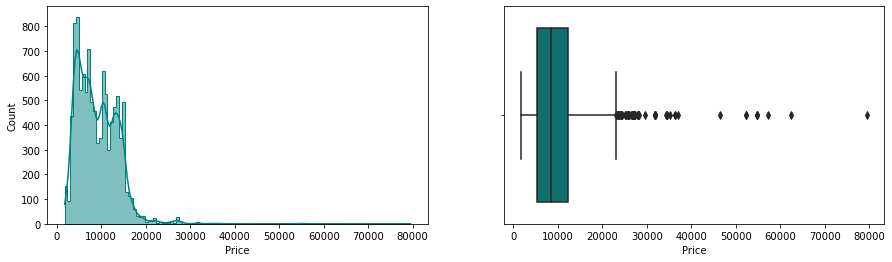

In [47]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 2, 1)
sns.histplot(train_data['Price'], kde=True, color='teal', stat='count', element='step')

plt.subplot(1, 2, 2)
sns.boxplot(x='Price', data=train_data, color='teal')

plt.show()

In [48]:
train_data[train_data['Price'] > 40000]

,Airline,Source,Destination,Total_Stops,Price,Journey_Day,Journey_Month,Dep_Time_Hours,Dep_Time_Minutes,Arrival_Time_Hours,Arrival_Time_Minutes,Duration_Hours,Duration_Minutes,Route_1,Route_2,Route_3,Route_4,Route_5
657,Jet Airways Business,Banglore,New Delhi,1,52229,3,1,5,45,10,45,5,0,BLR,BOM,DEL,None,None
1478,Jet Airways,Banglore,New Delhi,1,54826,18,3,18,40,0,45,6,5,BLR,BOM,DEL,None,None
2618,Jet Airways,Banglore,New Delhi,1,54826,18,3,22,50,5,5,6,15,BLR,BOM,DEL,None,None
2924,Jet Airways Business,Banglore,New Delhi,1,79512,3,1,5,45,11,25,5,40,BLR,BOM,DEL,None,None
5372,Jet Airways Business,Banglore,New Delhi,1,62427,3,1,5,45,12,25,6,40,BLR,BOM,DEL,None,None
5439,Jet Airways,Banglore,New Delhi,1,54826,3,1,16,55,23,0,6,5,BLR,BOM,DEL,None,None
7351,Jet Airways Business,Delhi,Cochin,2,46490,3,3,20,5,4,25,8,20,DEL,ATQ,BOM,COK,None
9715,Jet Airways Business,Delhi,Cochin,2,52285,3,6,20,5,4,25,8,20,DEL,ATQ,BOM,COK,None
10364,Jet Airways Business,Banglore,New Delhi,1,57209,3,1,9,45,14,25,4,40,BLR,MAA,DEL,None,None


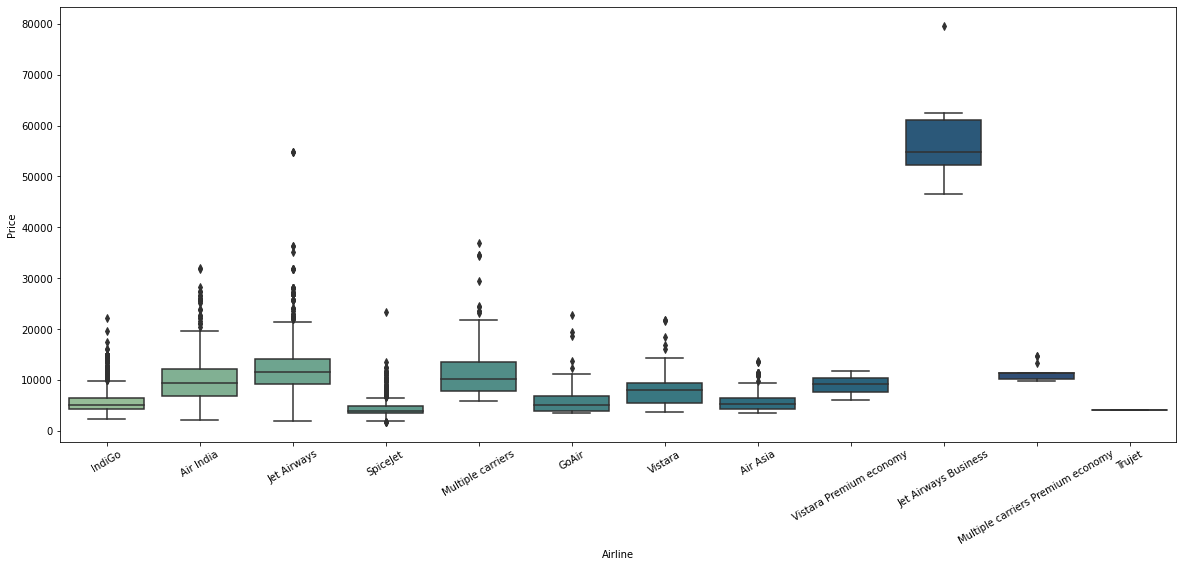

In [49]:
plt.figure(figsize=(20,8))
sns.boxplot(x='Airline', y='Price', data=train_data, palette='crest')
plt.xticks(rotation=30)
plt.show()

As shown on the table above, the data that have price over 40000 are from Jet Airways Business Airline and Jet Airways Airline. But, I assume that the Jet Airways Business Airline prices are not wrong data. Because based on the price distribution each airline on the boxplot above, the Jet Airways Business Airline has the highest price distribution. So, let's continue to check the price distribution of Jet Airways Airline.

In [50]:
train_data[(train_data['Price'] > 40000) & (train_data['Airline'] == 'Jet Airways')]

,Airline,Source,Destination,Total_Stops,Price,Journey_Day,Journey_Month,Dep_Time_Hours,Dep_Time_Minutes,Arrival_Time_Hours,Arrival_Time_Minutes,Duration_Hours,Duration_Minutes,Route_1,Route_2,Route_3,Route_4,Route_5
1478,Jet Airways,Banglore,New Delhi,1,54826,18,3,18,40,0,45,6,5,BLR,BOM,DEL,None,None
2618,Jet Airways,Banglore,New Delhi,1,54826,18,3,22,50,5,5,6,15,BLR,BOM,DEL,None,None
5439,Jet Airways,Banglore,New Delhi,1,54826,3,1,16,55,23,0,6,5,BLR,BOM,DEL,None,None


Based on table above, we can see that the data that has the price above 40000 and the airline is Jet Airways have similar values on the several features, like `Source`, `Destination`, and `Duration_Hours`. Then, let's check all data that have those similar features.

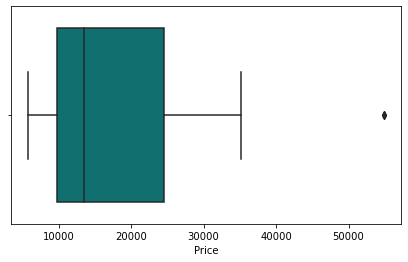

In [51]:
plt.figure(figsize=(7, 4))
sns.boxplot(data = train_data[(train_data['Airline'] == 'Jet Airways') & 
                           (train_data['Source'] == 'Banglore') & 
                           (train_data['Destination'] == 'New Delhi') & 
                           (train_data['Duration_Hours'] == 6)], 
            x = 'Price', color='teal')
plt.show()

In [52]:
train_data[(train_data['Airline'] == 'Jet Airways') & 
           (train_data['Source'] == 'Banglore') & 
           (train_data['Destination'] == 'New Delhi') & 
           (train_data['Duration_Hours'] == 6)]['Price'].median()

13555.0

In [53]:
train_data['Price'] = np.where((train_data['Price'] > 40000) & (train_data['Airline'] == 'Jet Airways'),
                               13555, train_data['Price'])

In [54]:
train_data['Price'].skew()

1.6116154774005362

As shown on the boxplot above, in general, the distribution price of same `Source`, `Destination`, and `Duration_Hours` from the outliers in Jet Airways Airline are different to others. So that's why, I replace it with its median.

# 3. Exploratory Data Analysis

In [55]:
def summary(df):
    dtype = []
    nan = []
    nan_perc = []
    nunique = []
    unique = []
    
    for i in df.columns:
        dtype.append(df[i].dtype)
        nan.append(df[i].isna().sum())
        nan_perc.append((df[i].isna().sum()/len(df[i]))*100)
        nunique.append(df[i].nunique())
        val_counts = df[i].value_counts(normalize=True)
        unique.append(list(val_counts.index))
    
    summary_df = pd.DataFrame({'dtype': dtype, 'nan' : nan, 'nan_perc' : nan_perc, 'nunique' : nunique, 'unique': unique}, index=df.columns)
    
    return display(summary_df)

In [56]:
summary(train_data)

,dtype,nan,nan_perc,nunique,unique
Airline,object,0,0.0,12,"[Jet Airways, IndiGo, Air India, Multiple carr..."
Source,object,0,0.0,5,"[Delhi, Kolkata, Banglore, Mumbai, Chennai]"
Destination,object,0,0.0,6,"[Cochin, Banglore, Delhi, New Delhi, Hyderabad..."
Total_Stops,int64,0,0.0,5,"[1, 0, 2, 3, 4]"
Price,int64,0,0.0,1869,"[10262, 10844, 7229, 4804, 4823, 14714, 3943, ..."
Journey_Day,int64,0,0.0,9,"[6, 5, 3, 27, 21, 24, 15, 18, 4]"
Journey_Month,int64,0,0.0,7,"[6, 3, 5, 9, 1, 12, 4]"
Dep_Time_Hours,int64,0,0.0,24,"[9, 7, 8, 17, 6, 20, 5, 11, 19, 10, 14, 21, 16..."
Dep_Time_Minutes,int64,0,0.0,12,"[0, 30, 55, 10, 45, 5, 15, 25, 20, 35, 50, 40]"
Arrival_Time_Hours,int64,0,0.0,24,"[19, 12, 4, 21, 22, 1, 18, 9, 23, 10, 8, 7, 20..."


In [57]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Total_Stops,10682.0,0.824190,0.675229,0.0,0.0,1.0,1.0,4.0
Price,10682.0,9075.623760,4547.995043,1759.0,5277.0,8372.0,12373.0,79512.0
Journey_Day,10682.0,12.682925,8.803800,3.0,5.0,6.0,21.0,27.0
Journey_Month,10682.0,5.534731,2.987626,1.0,3.0,5.0,6.0,12.0
Dep_Time_Hours,10682.0,12.491013,5.748820,0.0,8.0,11.0,18.0,23.0
Dep_Time_Minutes,10682.0,24.409287,18.767801,0.0,5.0,25.0,40.0,55.0
Arrival_Time_Hours,10682.0,13.349186,6.859317,0.0,8.0,14.0,19.0,23.0
Arrival_Time_Minutes,10682.0,24.690601,16.506808,0.0,10.0,25.0,35.0,55.0
Duration_Hours,10682.0,10.244898,8.494916,0.0,2.0,8.0,15.0,47.0
Duration_Minutes,10682.0,28.326624,16.945817,0.0,15.0,30.0,45.0,55.0


## A. Jet Airways Business is the Highest Price Airline

In [58]:
train_data.groupby(['Airline']).median()['Price'].sort_values(ascending=False).reset_index()

,Airline,Price
0,Jet Airways Business,54747.0
1,Jet Airways,11467.0
2,Multiple carriers Premium economy,11269.0
3,Multiple carriers,10197.0
4,Air India,9443.0
5,Vistara Premium economy,9125.0
6,Vistara,7980.0
7,Air Asia,5162.0
8,GoAir,5135.0
9,IndiGo,5000.0


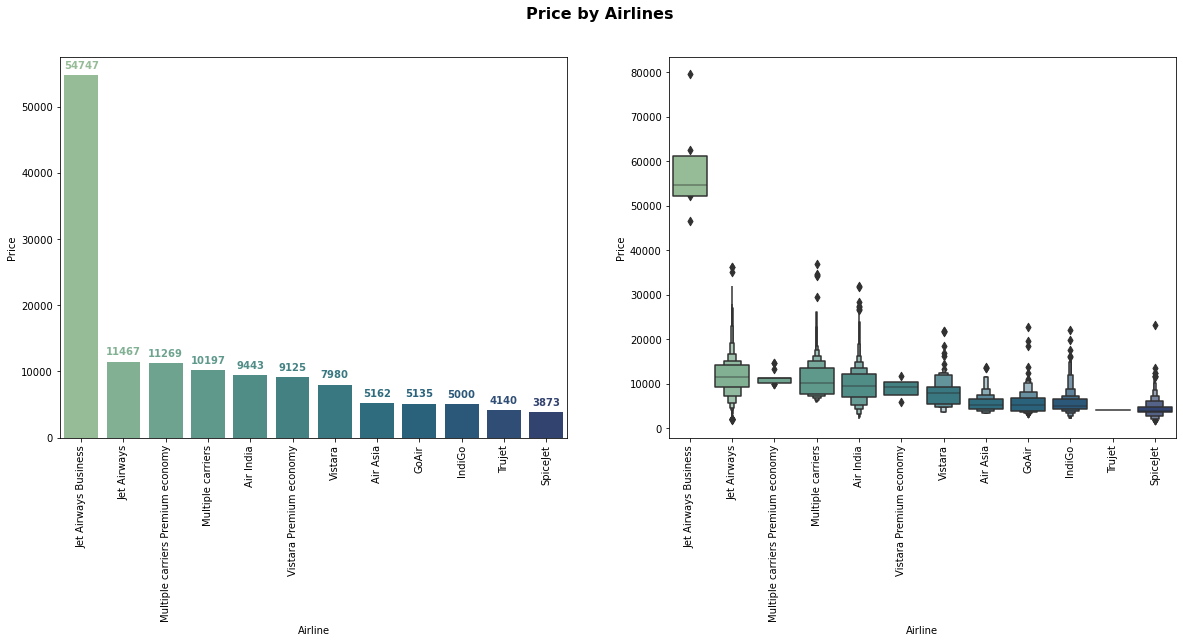

In [59]:
df_airline = train_data.groupby(['Airline']).median()['Price'].sort_values(ascending=False).reset_index()
order_airline = df_airline['Airline']

fig = plt.figure(figsize=(20, 7))

plt.subplot(1, 2, 1)
g = sns.barplot(x='Airline', y='Price', data=df_airline, order=order_airline, ci=None, palette='crest')
for idx, p in enumerate(g.patches) :
    g.text(x=idx, y=p.get_height()+1500, s=int(p.get_height()),
           ha='center', va='center', 
           fontweight='bold', color=p.get_fc())
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
sns.boxenplot(x='Airline', y='Price', data=train_data, order=order_airline, palette='crest')
plt.xticks(rotation=90)

fig.suptitle('Price by Airlines', fontsize='16', fontweight='bold')
plt.show()

Different from the other airlines, Jet Airways Business has the highest median price and has the highest range price. It has big gap from the others, where the others have similar median price and range. 

## B. South Part of India is the Most Favourite Destination

In [60]:
dest_df = train_data.groupby('Destination').agg(Count=('Destination', 'size'), 
                                                Price=('Price', 'median')).reset_index().sort_values('Count', ascending=False)
dest_df

,Destination,Count,Price
1,Cochin,4536,10262.0
0,Banglore,2871,9345.0
2,Delhi,1265,4823.0
5,New Delhi,932,10898.5
3,Hyderabad,697,3342.0
4,Kolkata,381,3850.0


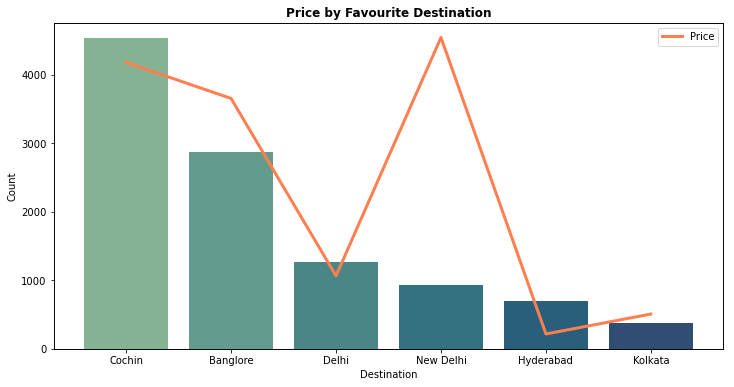

In [61]:
fig, ax1 = plt.subplots(figsize=(12,6))

sns.barplot(x='Destination', y='Count', data=dest_df, ax=ax1, palette='crest')

ax2 = ax1.twinx()
sns.lineplot(x='Destination', y='Price', data=dest_df, sort=False, ax=ax2, color='coral', linewidth=3, label='Price')
ax2.set_yticklabels([])
ax2.set_yticks([])
ax2.set_ylabel(None)

plt.title('Price by Favourite Destination', fontsize='12', fontweight='bold')
plt.show()

There are six destinations providing by airlines in this dataset. On the chart above, it shows favourite destination (bar chart) overlayed by price (orange line chart). Based on that chart, Cochin and Banglore located in south part of India become favourite destination. Then, followed by Delhi, New Delhi, Hyderabad, and Kolkata. Cochin and Banglore also have high median price. Even though, the highest median price of destination is New Delhi. 

## C. June is the Busiest Flight

In [62]:
month_df = train_data.groupby('Journey_Month').agg(Count=('Journey_Month', 'size'), 
                                                   Price=('Price', 'median')).reset_index()

month_df['Journey_Month'] = month_df['Journey_Month'].replace([1,3,4,5,6,9,12], 
                                                              ['Jan', 'Mar', 'Apr', 'May', 'Jun', 'Sep', 'Dec'])

month_df

,Journey_Month,Count,Price
0,Jan,1075,8937
1,Mar,2211,7532
2,Apr,424,4924
3,May,2074,9345
4,Jun,2535,8662
5,Sep,1406,9482
6,Dec,957,8996


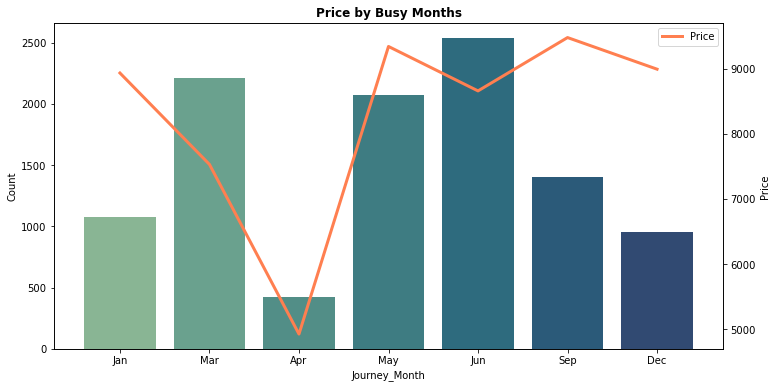

In [63]:
fig, ax3 = plt.subplots(figsize=(12,6))

sns.barplot(x='Journey_Month', y='Count', data=month_df, ax=ax3, palette='crest')

ax4 = ax3.twinx()
sns.lineplot(x='Journey_Month', y='Price', data=month_df, ax=ax4, color='coral', linewidth=3, label='Price')
ax2.set_yticklabels([])
ax2.set_yticks([])
ax2.set_ylabel(None)

plt.title('Price by Busy Months', fontsize='12', fontweight='bold')
plt.show()

In this dataset, there are several months that do not have recorded data. On the chart above, it shows months ordered from January, March, April, May, June Sepetember, and December (bar chart) overlayed by price (orange line chart).There are many airlines flights on June. However, the pattern of the number of flights each month is not followed by the price. I can assume that people avoid high airfares (Jan, Sep, Dec). 

## D. More Stops Can Increase Airfares

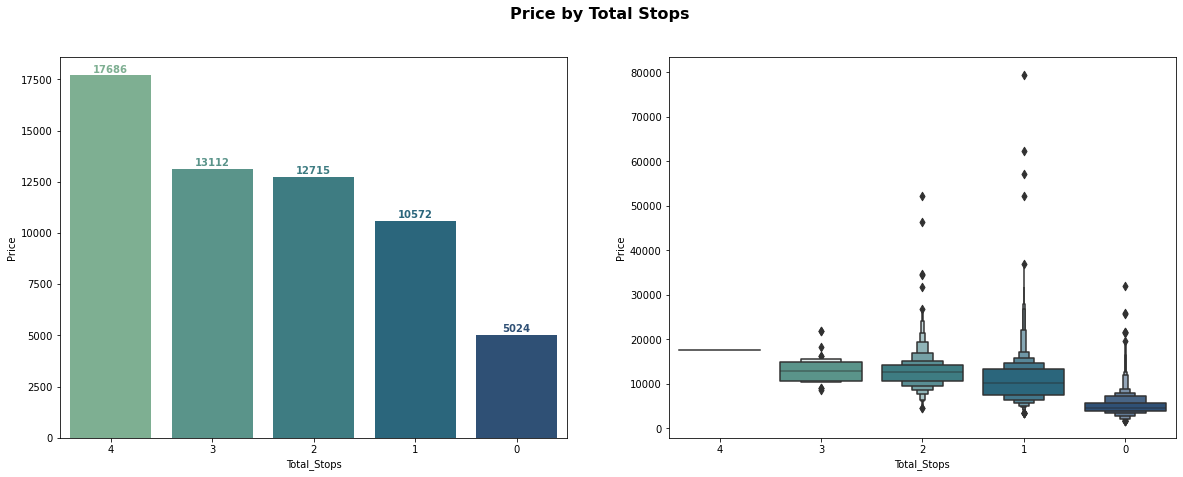

In [64]:
df_stop = train_data.groupby(['Total_Stops']).median()['Price'].sort_values(ascending=False).reset_index()
order_stop = df_stop['Total_Stops']

fig = plt.figure(figsize=(20, 7))

plt.subplot(1, 2, 1)
g = sns.barplot(x='Total_Stops', y='Price', data=train_data, order=order_stop, ci=None, palette='crest')
for idx, p in enumerate(g.patches) :
    g.text(x=idx, y=p.get_height()+300, s=int(p.get_height()),
           ha='center', va='center', 
           fontweight='bold', color=p.get_fc())

plt.subplot(1, 2, 2)
sns.boxenplot(x='Total_Stops', y='Price', data=train_data, order=order_stop, palette='crest')

fig.suptitle('Price by Total Stops', fontsize='16', fontweight='bold')
plt.show()

When we want to save expenses, find the direct flights. As shown chart above, if we take indirect flights to our destination, the price will increase. And the gap median price of direct flights compared to indirect flights is far.

# 3. Modeling

## A. Preparation

In this case, regression machine learnings is used to predict airfare. There are several regression algoritms that are applied, namely Ridge Regression, K-Nearest Neighbor Regressor, and Random Forest Resgressor. To find the best model, those three machine learning alghorithms will be compared using default parameters first. Then, the best score of benchmark model will be continued to hyperparameter tuning step to find the best parameters. The modeling process is done end-to-end using Pipeline to avoid data leakage. Each pipeline is started with a Column Transformer that has a function to manipulate several features so that it can be read by the machine learning alorithms.

The input data used for machine learning model are different from original data. Where, the originial data have been processed, cleaned, and extracted new features previously. The features used are shown below:

In [65]:
summary(train_data)

,dtype,nan,nan_perc,nunique,unique
Airline,object,0,0.0,12,"[Jet Airways, IndiGo, Air India, Multiple carr..."
Source,object,0,0.0,5,"[Delhi, Kolkata, Banglore, Mumbai, Chennai]"
Destination,object,0,0.0,6,"[Cochin, Banglore, Delhi, New Delhi, Hyderabad..."
Total_Stops,int64,0,0.0,5,"[1, 0, 2, 3, 4]"
Price,int64,0,0.0,1869,"[10262, 10844, 7229, 4804, 4823, 14714, 3943, ..."
Journey_Day,int64,0,0.0,9,"[6, 5, 3, 27, 21, 24, 15, 18, 4]"
Journey_Month,int64,0,0.0,7,"[6, 3, 5, 9, 1, 12, 4]"
Dep_Time_Hours,int64,0,0.0,24,"[9, 7, 8, 17, 6, 20, 5, 11, 19, 10, 14, 21, 16..."
Dep_Time_Minutes,int64,0,0.0,12,"[0, 30, 55, 10, 45, 5, 15, 25, 20, 35, 50, 40]"
Arrival_Time_Hours,int64,0,0.0,24,"[19, 12, 4, 21, 22, 1, 18, 9, 23, 10, 8, 7, 20..."


In [66]:
train_data.columns

Index(['Airline', 'Source', 'Destination', 'Total_Stops', 'Price',
       'Journey_Day', 'Journey_Month', 'Dep_Time_Hours', 'Dep_Time_Minutes',
       'Arrival_Time_Hours', 'Arrival_Time_Minutes', 'Duration_Hours',
       'Duration_Minutes', 'Route_1', 'Route_2', 'Route_3', 'Route_4',
       'Route_5'],
      dtype='object')

In [67]:
num_cols = train_data.select_dtypes('number').drop('Price', axis=1).columns
train_data[num_cols].head(3)

,Total_Stops,Journey_Day,Journey_Month,Dep_Time_Hours,Dep_Time_Minutes,Arrival_Time_Hours,Arrival_Time_Minutes,Duration_Hours,Duration_Minutes
0,0,24,3,22,20,1,10,2,50
1,2,5,1,5,50,13,15,7,25
2,2,6,9,9,25,4,25,19,0


In [68]:
onehot_cols = ['Source', 'Destination']
train_data[onehot_cols].head(3)

,Source,Destination
0,Banglore,New Delhi
1,Kolkata,Banglore
2,Delhi,Cochin


In [69]:
bin_cols = ['Airline', 'Route_1', 'Route_2', 'Route_3', 'Route_4','Route_5']
train_data[bin_cols].head(3)

,Airline,Route_1,Route_2,Route_3,Route_4,Route_5
0,IndiGo,BLR,DEL,None,None,None
1,Air India,CCU,IXR,BBI,BLR,None
2,Jet Airways,DEL,LKO,BOM,COK,None


## B. Data Splitting

In [70]:
X = train_data.drop('Price', axis=1)
y = train_data['Price']

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=2021)

In [72]:
for i in X_train, X_test, y_train, y_test :
    print(i.shape)

(8545, 17)
(2137, 17)
(8545,)
(2137,)


## C. Parameter Setting

### Column Transformer

As mentioned before, the pipeline is started with the column transformer. Here, three column transformers that can be used in the pipeline :
- __numscaled_pipe__, is used for transforming all numerical features in the KNN Regressor algorithm only.
- __onehote_pipe__, is used for transforming categrical features using One-Hot Encoder.
- __binary_pipe__, is used for transforming categorical features using BinaryEncoder.

In [73]:
numscaled_pipe = Pipeline([
    ('scaler', RobustScaler())
])

onehot_pipe = Pipeline([
    ('onehot', OneHotEncoder(drop='first'))
])

binary_pipe = Pipeline([
    ('binary', ce.BinaryEncoder())
])

### Cross Validation Parameters

In [74]:
kf = KFold(n_splits=5, random_state=2021, shuffle=True)

### Model Evaluation Function

In [75]:
def cross_val_result(model_score, model_name) :
    plt.figure(figsize=(8,5))
    plt.plot(np.arange(1,6,1), model_score, marker='o', color='teal', 
             label=f'R2 (mean = {round(abs(model_score.mean()), 2)})')
    plt.title('Cross Validation Score of {}'.format(model_name), fontweight='bold')
    plt.xlabel('Fold')
    plt.ylabel('Score')
    plt.xticks(np.arange(1,6,1))
    plt.legend()
    plt.show()

In [76]:
def evaluation_model(test, pred) :
    residual = test-pred

    fig=plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(residual, kde=True, stat='density', element='step', color='teal')


    plt.subplot(1, 2, 2)
    sns.boxplot(x=residual, color='teal')

    fig.suptitle('Residual Distribution', fontsize='16', fontweight='bold')
    plt.show()

    print('R2 :', r2_score(test, pred))
    print('RMSE:', np.sqrt(mean_squared_error(test, pred)))
    print('MAE :', mean_absolute_error(test, pred))

## D. Ridge Performance

### Ridge Pipeline

In [77]:
ridge_transformer = ColumnTransformer([
    ('binary_pipe', binary_pipe, bin_cols),
    ('onehot_pipe', onehot_pipe, onehot_cols), 
], remainder='passthrough')

ridge_pipe = Pipeline([
    ('transformer', ridge_transformer),
    ('ridge', Ridge(alpha=1, random_state=2021))
])

### Cross Validation Score 

In [78]:
ridge_score = cross_val_score(ridge_pipe, X_train, y_train, scoring='r2', cv=kf, n_jobs=-1)

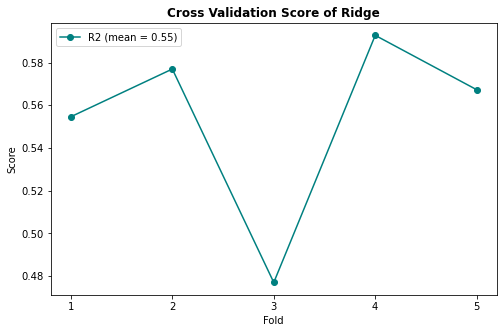

In [79]:
cross_val_result(ridge_score, 'Ridge')

### Test Score

In [83]:
ridge_default = ridge_pipe.fit(X_train, y_train)
y_pred_ridge_default = ridge_default.predict(X_test)

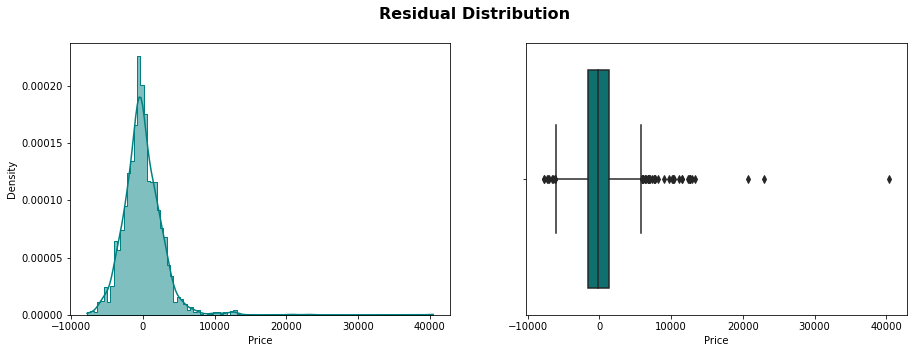

R2 : 0.61943743976457
RMSE: 2800.807142513577
MAE : 1952.2703831319993


In [84]:
evaluation_model(y_test, y_pred_ridge_default)

## E. KNN Regressor Performance

### KNN Regressor Pipeline

In [85]:
knn_transformer = ColumnTransformer([
    ('num_pipe', numscaled_pipe, num_cols),
    ('binary_pipe', binary_pipe, bin_cols),
    ('onehot_pipe', onehot_pipe, onehot_cols), 
], remainder='passthrough')

knn_pipe = Pipeline([
    ('transformer', knn_transformer),
    ('knn', KNeighborsRegressor())
])

### Cross Validation Score

In [86]:
knn_score = cross_val_score(knn_pipe, X_train, y_train, scoring='r2', cv=kf, n_jobs=-1)

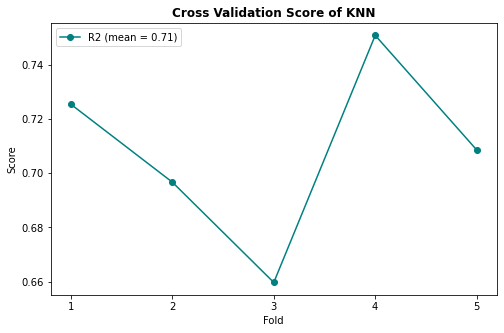

In [87]:
cross_val_result(knn_score, 'KNN')

### Test Score

In [88]:
knn_default = knn_pipe.fit(X_train, y_train)
y_pred_knn_default = knn_default.predict(X_test)

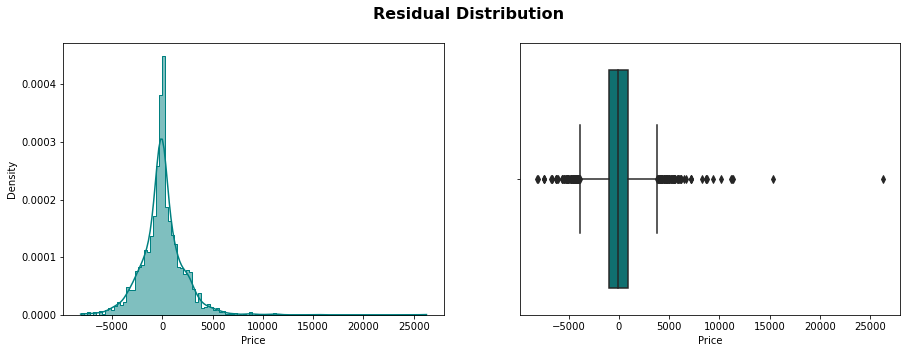

R2 : 0.7747556416802462
RMSE: 2154.7512247369486
MAE : 1443.831352363126


In [89]:
evaluation_model(y_test, y_pred_knn_default)

## F. Random Forest Regressor Performance

### Random Forest Regressor Pipeline

In [90]:
rfr_transformer = ColumnTransformer([
    ('binary_pipe', binary_pipe, bin_cols),
    ('onehot_pipe', onehot_pipe, onehot_cols), 
], remainder='passthrough')

rfr_pipe = Pipeline([
    ('transformer', ridge_transformer),
    ('rfr', RandomForestRegressor(random_state=2021))
])

### Cross Validation Score

In [91]:
rfr_score = cross_val_score(rfr_pipe, X_train, y_train, scoring='r2', cv=kf, n_jobs=-1)

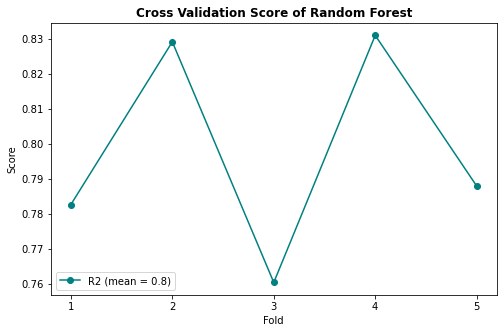

In [92]:
cross_val_result(rfr_score, 'Random Forest')

### Test Score

In [93]:
rfr_default = rfr_pipe.fit(X_train, y_train)
y_pred_rfr_default = rfr_default.predict(X_test)

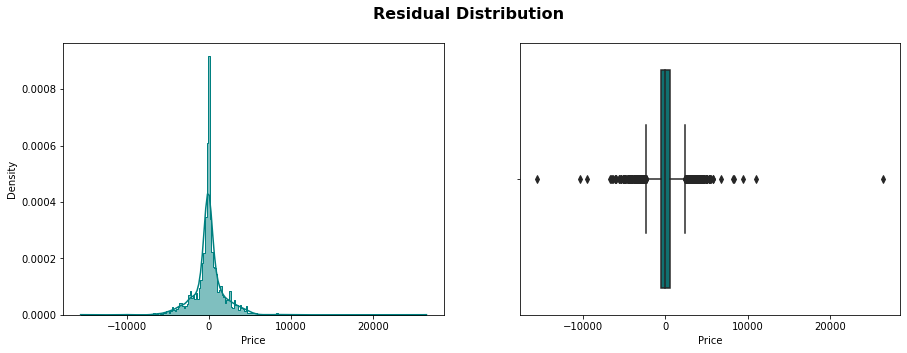

R2 : 0.8205237846318412
RMSE: 1923.4177815719272
MAE : 1178.082420094386


In [94]:
evaluation_model(y_test, y_pred_rfr_default)

## G. Benchmark Models Comparison

In [95]:
summary_model = pd.DataFrame()
summary_model['Models'] = ['Ridge', 'Ridge', 'Ridge', 'KNN', 'KNN', 'KNN', 'Random Forest', 'Random Forest', 'Random Forest']
summary_model['Metrics'] = ['R2', 'RMSE', 'MAE']*3
model_score = []
for i in [y_pred_ridge_default, y_pred_knn_default, y_pred_rfr_default] :
    model_score.extend([r2_score(y_test, i), np.sqrt(mean_squared_error(y_test, i)), mean_absolute_error(y_test, i)])
summary_model['Scores'] = model_score

In [100]:
summary_model.pivot(index='Models', columns='Metrics', values='Scores').sort_values('MAE')

Metrics,MAE,R2,RMSE
Models,,,
Random Forest,1178.082420,0.820524,1923.417782
KNN,1443.831352,0.774756,2154.751225
Ridge,1952.270383,0.619437,2800.807143


After running the machine learning algorithms with default parameters, each alhorithm results evaluation metric scores (MAE, R2, RMSE) shown in table above. Because in the Residual Distribution plot of each algorithm results many outliers, I will focus on the MAE score as evaluation metric. Where, the MAE is less sensitive to outliers in the residual. 

The best model is the model that has the smallest MAE score. Based on the table above, Random Forest has the smallest MAE score and become the best model. Not only has smallest MAE score, but also Random Forest has the highest R2 score and the smallest RMSE score. For the next step, The Random Forest algorithm will be continued to Hyperparameter Tuning process. In that step, We find the best parameters to increace the MAE score.

## H. Hyperparameter Tuning of Random Forest Regressor 

In [134]:
rfr_pipe.get_params()

{'memory': None,
 'steps': [('transformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('binary_pipe',
                                    Pipeline(steps=[('binary', BinaryEncoder())]),
                                    ['Airline', 'Route_1', 'Route_2', 'Route_3',
                                     'Route_4', 'Route_5']),
                                   ('onehot_pipe',
                                    Pipeline(steps=[('onehot',
                                                     OneHotEncoder(drop='first'))]),
                                    ['Source', 'Destination'])])),
  ('rfr', RandomForestRegressor(random_state=2021))],
 'verbose': False,
 'transformer': ColumnTransformer(remainder='passthrough',
                   transformers=[('binary_pipe',
                                  Pipeline(steps=[('binary', BinaryEncoder())]),
                                  ['Airline', 'Route_1', 'Route_2', 'Route_3',
                           

Hyperparameter Tuning is processed by GridSearchCV. This method helps to loop through predefined hyperparameters and fit the model. In the end, We can get the best parameters from the listed hyperparameters. The listed hyperparameters can be seen in the rfr_params variable below.

In [140]:
rfr_params = {
    'rfr__max_depth': np.arange(6, 16, 2),
    'rfr__min_samples_split': [2, 5, 10],
    'rfr__min_samples_leaf': [1, 2, 5],
    'rfr__n_estimators': [100, 500, 1000]
}

grid_rfr = GridSearchCV(
    rfr_pipe, # model yang mau di tune
    param_grid = rfr_params, # hyperparameter option
    cv = kf, # evaluation method
    scoring = 'neg_mean_absolute_error', # metrics
    n_jobs = -1,
    verbose = 2
)
 
grid_rfr.fit(X_train, y_train)

Fitting 5 folds for each of 135 candidates, totalling 675 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 29.7min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 57.8min
[Parallel(n_jobs=-1)]: Done 675 out of 675 | elapsed: 61.8min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=2021, shuffle=True),
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('binary_pipe',
                                                                         Pipeline(steps=[('binary',
                                                                                          BinaryEncoder())]),
                                                                         ['Airline',
                                                                          'Route_1',
                                                                          'Route_2',
                                                                          'Route_3',
                                                                          'Route_4',
                                                                       

In [141]:
grid_rfr.best_params_

{'rfr__max_depth': 14,
 'rfr__min_samples_leaf': 1,
 'rfr__min_samples_split': 2,
 'rfr__n_estimators': 500}

In [143]:
rfr_tuned = grid_rfr.best_estimator_.fit(X_train, y_train)
y_pred_rfr_tuned = rfr_tuned.predict(X_test)

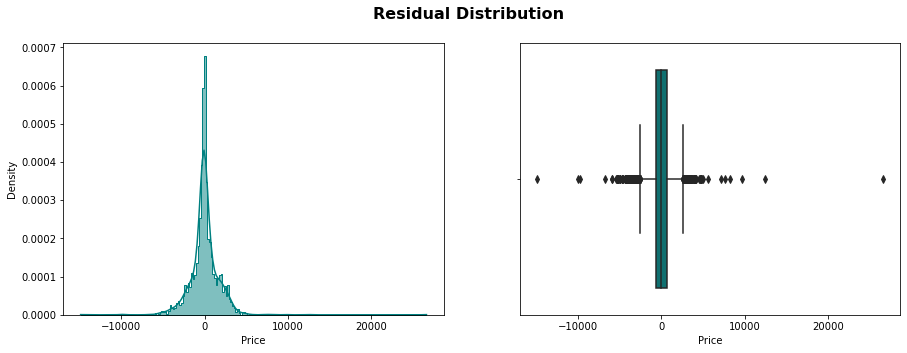

R2 : 0.8533943647357356
RMSE: 1738.3831641313207
MAE : 1095.3583359410964


In [144]:
evaluation_model(y_test, y_pred_rfr_tuned)

After processing hyperparameter tuning step, We can see that the MAE score has decreased from 1178.08 to 1095.35. This Random Forest with hyperparameter tuned model could be implemented on the deployment if needed.

## I. Save The Best Model

In [148]:
rfr_tuned.fit(X, y)
filename = 'Random_Forest.sav'
pickle.dump(rfr_tuned, open(filename, 'wb'))

In [149]:
filename = 'Random_Forest.sav'
loaded_model = pickle.load((open(filename, 'rb')))

In [150]:
loaded_model

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('binary_pipe',
                                                  Pipeline(steps=[('binary',
                                                                   BinaryEncoder())]),
                                                  ['Airline', 'Route_1',
                                                   'Route_2', 'Route_3',
                                                   'Route_4', 'Route_5']),
                                                 ('onehot_pipe',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['Source', 'Destination'])])),
                ('rfr',
                 RandomForestRegressor(max_depth=14, n_estimators=500,
                                       ra

## J. Predict New Data

In [166]:
df_predict = pd.DataFrame({
    'Airline' : 'Air Asia', 
    'Source' : 'Delhi', 
    'Destination' : 'Cochin', 
    'Total_Stops' : [1], 
    'Journey_Day' : [31],
    'Journey_Month' : [5], 
    'Dep_Time_Hours' : [5], 
    'Dep_Time_Minutes' : [10],
    'Arrival_Time_Hours' : [12], 
    'Arrival_Time_Minutes' : [40], 
    'Duration_Hours' : [7],
    'Duration_Minutes' : [30], 
    'Route_1' : 'DEL', 
    'Route_2' : 'NAG', 
    'Route_3' : 'BLR', 
    'Route_4' : 'None',
    'Route_5' : 'None'
})

df_predict

,Airline,Source,Destination,Total_Stops,Journey_Day,Journey_Month,Dep_Time_Hours,Dep_Time_Minutes,Arrival_Time_Hours,Arrival_Time_Minutes,Duration_Hours,Duration_Minutes,Route_1,Route_2,Route_3,Route_4,Route_5
0,Air Asia,Delhi,Cochin,1,31,5,5,10,12,40,7,30,DEL,NAG,BLR,None,None


In [171]:
prediction = loaded_model.predict(df_predict)[0]
print('YOUR TICKET PRICE :', round(prediction))

YOUR TICKET PRICE : 6469
